# PyTorch之数据加载和处理

PyTorch提供了许多工具来简化和希望数据加载，使代码更具可读性。

## 1.下载安装包

* scikit-image：用于图像的IO和变换
* pandas：用于更容易地进行csv解析


In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd # analyze the csv file
from skimage import io, transform # image io and transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# ingore the warning
import warnings
warnings.filterwarnings("ignore")

plt.ion() # interactive mode

## 2.下载数据集

从[此处](https://download.pytorch.org/tutorial/faces.zip)下载数据集， 数据存于“data / faces /”的目录中。这个数据集实际上是imagenet数据集标注为face的图片当中在 dlib 面部检测 (dlib’s pose estimation) 表现良好的图片。我们要处理的是一个面部姿态的数据集。也就是按如下方式标注的人脸: 
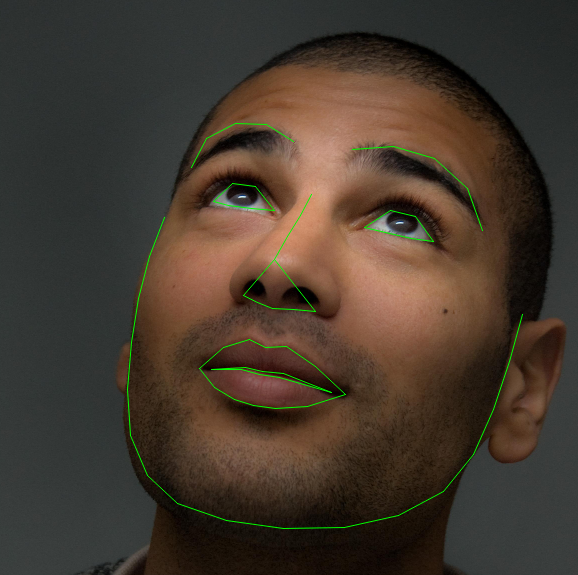

## 2.1 数据集注释

数据集是按如下规则打包成的csv文件:

`
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
`

## 3.读取数据集

将csv中的标注点数据读入（N，2）数组中，其中N是特征点的数量。读取数据代码如下：

In [2]:
landmarks_frame = pd.read_csv('../data/faces/face_landmarks.csv')

In [3]:
landmarks_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,...,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


In [4]:
n = 65

# iloc : index locate
img_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n,1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1,2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


## 4 编写函数

写一个简单的函数来展示一张图片和它对应的标注点作为例子。

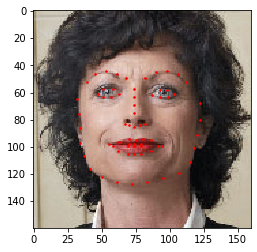

In [5]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0],landmarks[:,1],s = 10,marker='.',c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('../data/faces/',img_name)),landmarks)
plt.show()

# 5.数据集类

torch.utils.data.Dataset是表示数据集的抽象类，因此自定义数据集应继承Dataset并覆盖以下方法

* __len__ 实现 len(dataset) 返还数据集的尺寸。
* __getitem__用来获取一些索引数据，例如 dataset[i] 中的(i)。


5.1 建立数据集类

为面部数据集创建一个数据集类。我们将在 __init__ 中读取csv的文件内容，在 __getitem__中读取图片。这么做是为了节省内存 空间。只有在需要用到图片的时候才读取它而不是一开始就把图片全部存进内存里。

我们的数据样本将按这样一个字典{'image': image, 'landmarks': landmarks}组织。 我们的数据集类将添加一个可选参数transform 以方便对样本进行预处理。下一节我们会看到什么时候需要用到transform参数。 __init__方法如下图所示：

In [6]:
class FaceLandMarksData(Dataset):
    """ 面部标记数据集"""
    
    def __init__(self, csv_file, root_dir,transform=None):
        """
        csv_file（string）：带注释的csv文件的路径。
        root_dir（string）：包含所有图像的目录。
        transform（callable， optional）：一个样本上的可用的可选变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
        
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,
                               self.landmarks_frame.iloc[idx,0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx,1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}
    
        if self.transform:
            sample = self.transform(sample)
            
        return sample

## 6.数据可视化

实例化这个类并遍历数据样本。我们将会打印出前四个例子的尺寸并展示标注的特征点。 代码如下图所示：

0 (324, 215, 3) (68, 2)


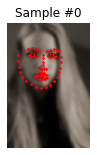

1 (500, 333, 3) (68, 2)


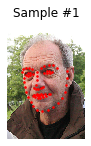

2 (250, 258, 3) (68, 2)


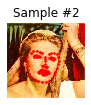

3 (434, 290, 3) (68, 2)


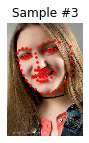

In [8]:
face_dataset = FaceLandMarksData(csv_file='../data/faces/face_landmarks.csv',
                                    root_dir='../data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


## 7.数据变换

通过上面的例子我们会发现图片并不是同样的尺寸。绝大多数神经网络都假定图片的尺寸相同。因此我们需要做一些预处理。让我们创建三个转换:

  * Rescale：缩放图片
  * RandomCrop：对图片进行随机裁剪。这是一种数据增强操作
  * ToTensor：把numpy格式图片转为torch格式图片 (我们需要交换坐标轴).

我们会把它们写成可调用的类的形式而不是简单的函数，这样就不需要每次调用时传递一遍参数。我们只需要实现__call__方法，必 要的时候实现 __init__ 方法。我们可以这样调用这些转换:

``
tsfm = Transform(params)
transformed_sample = tsfm(sample)
``

In [24]:
class Rescale(object):
    """将样本中的图像重新缩放到给定大小。.

    Args:
        output_size（tuple或int）：所需的输出大小。 如果是元组，则输出为
         与output_size匹配。 如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """
    
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        self.output_size = output_size
        
    def __call__(self,sample):
        images, landmarks = sample['image'], sample['landmarks']
        
        h, w = images.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(images, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}
    
class RandomCrop(object):
    """随机裁剪样本中的图像.

    Args:
       output_size（tuple或int）：所需的输出大小。 如果是int，方形裁剪是。         
    """
    
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        if isinstance(output_size,int):
            self.output_size = (output_size,output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                     left: left + new_w]
        
        landmarks = landmarks - [left,top]
        
        return {'image':image,'landmarks':landmarks}
    
class ToTenser(object):
    """将样本中的ndarrays转换为Tensors."""
    
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 交换颜色轴因为
        # numpy包的图片是: H * W * C
        # torch包的图片是: C * H * W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## 8.组合转换

接下来我们把这些转换应用到一个例子上。

我们想要把图像的短边调整为256，然后随机裁剪(randomcrop)为224大小的正方形。也就是说，我们打算组合一个Rescale和 RandomCrop的变换。 我们可以调用一个简单的类 torchvision.transforms.Compose来实现这一操作。具体实现如下图：

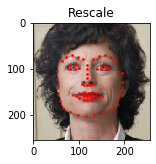

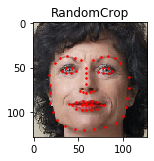

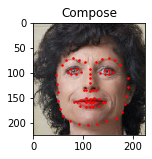

In [26]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]

for i, tsfrm in enumerate([scale,crop,composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

## 9.迭代数据集

让我们把这些整合起来以创建一个带组合转换的数据集。总结一下，每次这个数据集被采样时:

 * 及时地从文件中读取图片
 * 对读取的图片应用转换
 * 由于其中一步操作是随机的 (randomcrop) , 数据被增强了

我们可以像之前那样使用for i in range循环来对所有创建的数据集执行同样的操作。

In [27]:
transformed_dataset = FaceLandMarksData(csv_file='../data/faces/face_landmarks.csv',
                                       root_dir='../data/faces/',
                                       transform=transforms.Compose([
                                           Rescale(256),
                                           RandomCrop(224),
                                           ToTenser()
                                       ]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


但是，对所有数据集简单的使用for循环牺牲了许多功能，尤其是:

* 批量处理数据
* 打乱数据
* 使用多线程multiprocessingworker 并行加载数据。

`torch.utils.data.DataLoader`是一个提供上述所有这些功能的迭代器。下面使用的参数必须是清楚的。一个值得关注的参数是collate_fn, 可以通过它来决定如何对数据进行批处理。但是绝大多数情况下默认值就能运行良好。


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


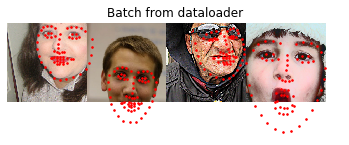

In [43]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                       shuffle=True, num_workers=0)

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

#   make_grid拼接多幅图像[B,C,H,W]
#     print(images_batch.size()) # [B,C,H,W]
    grid = utils.make_grid(images_batch,padding=0)
#     print(grid.size()) # [C,H,W*B]
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # 观察第4批次并停止。
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## 10.后记：torchvision

在这篇教程中我们学习了如何构造和使用数据集类(datasets),转换(transforms)和数据加载器(dataloader)。torchvision包提供了 常用的数据集类(datasets)和转换(transforms)。你可能不需要自己构造这些类。torchvision中还有一个更常用的数据集类ImageFolder。 它假定了数据集是以如下方式构造的:

``
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
``

其中'ants’,bees’等是分类标签。在PIL.Image中你也可以使用类似的转换(transforms)例如RandomHorizontalFlip,Scale。利 用这些你可以按如下的方式创建一个数据加载器(dataloader) :

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)